# Run CAD model on real dataset<sup>1,2</sup>
### Dataset cannot be automatically downloaded, please sign data use agreement here: https://physionet.org/content/ct-ich/1.3.1/

1. Hssayeni, M. (2020). Computed Tomography Images for Intracranial Hemorrhage Detection and Segmentation (version 1.3.1). PhysioNet. https://doi.org/10.13026/4nae-zg36.
2. Goldberger, A., et al (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

In [1]:
# load and create dataframes

import os
import sys
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm

from image_utils import *
from model_utils import *

path = Path('../datasets/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1/') # TODO: change directory
scan_path = Path.joinpath(path, 'ct_scans')

# load a modified version of Patient_demographics with cleaner headers
df = pd.read_csv('../datasets/MODIFIED_Patient_demographics.csv')
df = df.drop(df.columns[4:], axis=1) # remove lesion types
df.loc[df['Any_ICH'] != 0, 'Any_ICH'] = 1 # change # of ICH subtypes to binary 1/0
df['Model_Output'] = np.nan # add model output column

# there are six patients in Patient_demographics.csv with no images in the dataset; remove them
no_ct = [59, 60, 61, 61, 62, 63, 64, 65]
for case in no_ct:
    df.drop(df[df['Patient Number'] == case].index, inplace=True)
df.reset_index(drop=True, inplace=True)

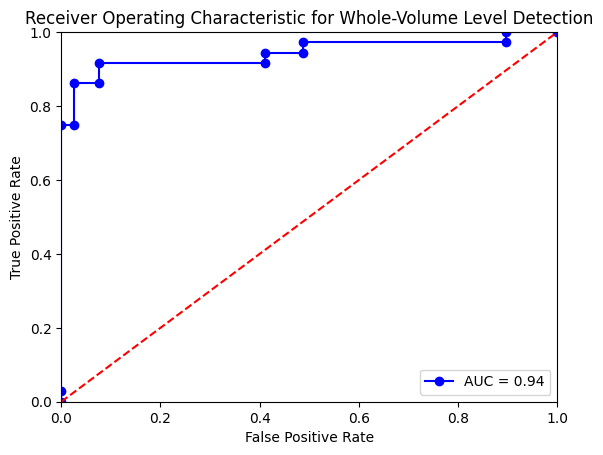

In [2]:
# Run CAD on real data
label_cols = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']
options = {
    'size': (480, 480),
    'save_jpg': False,
    'save_csv': True,
    'verbose': False,
    'native_resolution': True
}

if os.path.isfile('../datasets/real_dataset_predictions.csv'):
    df = pd.read_csv('../datasets/real_dataset_predictions.csv')
else:
    with tqdm(total=len(df)) as pbar:
        for index, row in df.iterrows():

            pbar.update(1)

            nifti_path = Path.joinpath(scan_path, str(row['Patient Number']).zfill(3) + '.nii')

            img, files = prepare_images(nifti_path, options, str(row['Patient Number']).zfill(3), 'saved_images/')
            output = classify_images(img, options)
            
            df.loc[index, 'Model_Output'] = np.max(output[:, -1])


    if options['save_csv']:
        df.to_csv('../datasets/real_dataset_predictions.csv')

results_real = df[["Any_ICH", "Model_Output"]].to_numpy()

# Get ROC
fpr_real, tpr_real, thresholds_real = metrics.roc_curve(df["Any_ICH"].to_numpy(), df["Model_Output"].to_numpy(), pos_label=1)
roc_df_real = pd.DataFrame(zip(fpr_real, tpr_real, thresholds_real),columns = ["FPR","TPR","Threshold"])

roc_auc = metrics.auc(fpr_real, tpr_real)

plt.title('Receiver Operating Characteristic for Whole-Volume Level Detection')
plt.plot(fpr_real, tpr_real, 'bo-', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Run CAD model on synthetic datasets

In [5]:
options = {
    'size': (480, 480),
    'save_jpg': False,
    'save_dcm': False,
    'save_csv': True,
    'verbose': False,
    'native_resolution': False # synthetic data is 1 mm, "True" will reformat to 5 mm
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device ' + str(device))

#dataset_path = Path('../datasets')
dataset_path = Path('/projects01/didsr-aiml/jayse.weaver/insilicoich/')
#dataset_names = ['mixed_2500_count']
dataset_names = ['mA_280_noME_standard_run1', 'mA_280_noME_standard_run2', 'mA_280_noME_standard_run3']

save_dir = '/home/jayse.weaver/temp_images/new/' # optional save directory if save_jpg or save_dcm = True

for dataset in dataset_names:
    print('Processing dataset: ' + str(dataset))
    path = dataset_path / dataset
    metadata = pd.concat([pd.read_csv(o) for o in path.rglob('metadata*.csv')], ignore_index=True)

    if options['save_csv']: metadata.to_csv(path / (str(dataset) + '_metadata.csv'))

    metadata_short = metadata.drop(metadata.columns[12:], axis=1)
    metadata_dropna = metadata_short.dropna()

    cases = sorted(os.listdir(path))
    cases = [case for case in cases if case.startswith('case')]

    labels_syn = []
    pred_syn = []
    type_syn = []
    volume_syn = []
    intensity_syn = []

    if options['native_resolution']:
        print('Processing in native resolution')
    else:
        print('Processing in 5 mm resolution')

    max_count = len(cases)
    description = 'Processing ' + str(len(cases)) + ' cases'

    with tqdm(total=max_count) as pbar:
        for index, case in enumerate(cases):

            pbar.update(1)

            id = str(case) + '_std'
            if os.path.isdir(Path.joinpath(path, case, 'lesion_masks/')): # check if case has mask and therefore hemorrhage
                labels_syn.append(1)

                # if case has hemorrhage, extract metadata from dataframe
                # TODO: fix insilicoICH metadata generation (currently messy with added strings and brackets)
                temp_df = metadata_dropna.loc[metadata_dropna['name'] == case]

                lesion_type = temp_df['lesion type'].unique()[0] #.split("'")[1]
                type_syn.append(lesion_type)

                volume_syn.append(temp_df['lesion volume [mL]'].sum())

                intensity = float(temp_df['intensity'].unique()[0][1:-1])
                intensity_syn.append(intensity)

            else: # case has no mask, therefore no hemorrhage
                labels_syn.append(0)
                type_syn.append('None')
                volume_syn.append('NaN')
                intensity_syn.append('NaN')

            dcm_path = Path.joinpath(path, case, 'dicoms/')

            img, files = prepare_images(dcm_path, options, id, save_dir)

            output = classify_images(img, options, device)
            pred_syn.append(np.max(output[:, -1]))

            if options['verbose']: print(np.max(output[:, -1]))

    fpr_syn, tpr_syn, thresholds_syn = metrics.roc_curve(labels_syn, pred_syn, pos_label=1)
    roc_df_syn = pd.DataFrame(zip(fpr_syn, tpr_syn, thresholds_syn),columns = ["FPR","TPR","Threshold"])

    roc_auc_syn = metrics.auc(fpr_syn, tpr_syn)

    all_cases = cases.copy()

    dfsyn = pd.DataFrame()
    dfsyn['case'] = all_cases
    dfsyn['truth'] = labels_syn
    dfsyn['pred'] = pred_syn
    dfsyn['type'] = type_syn
    dfsyn['volume'] = volume_syn
    dfsyn['intensity'] = intensity_syn

    if options['save_csv']: dfsyn.to_csv(path / (str(dataset) + '_results.csv'))
    
    # another optional CSV - this is just the FPR, TPR, and thresholds that can easily be created again from *_results.csv
    # if options['save_csv']: roc_df_syn.to_csv(path / (str(dataset) + '_ROC.csv'))

using device cuda
Processing dataset: mA_280_noME_standard_run1
Processing in 5 mm resolution


100%|██████████| 100/100 [17:04<00:00, 10.25s/it]


Processing dataset: mA_280_noME_standard_run2
Processing in 5 mm resolution


100%|██████████| 100/100 [16:35<00:00,  9.96s/it]


Processing dataset: mA_280_noME_standard_run3
Processing in 5 mm resolution


100%|██████████| 100/100 [17:48<00:00, 10.68s/it]


# ROC plot generation in create_ROC.ipynb